In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [ ]:
df = pd.read_excel("MED-Lab-1-Zadanie-1-Dane.xlsx", sheet_name="Uzytkownicy Q3'2008 -> Q4'2023", skiprows=[0])

In [ ]:
df.head()

,NoQ,QY,Users
0,1,Q3 '08,100
1,2,Q1 '09,197
2,3,Q2 '09,242
3,4,Q3 '09,305
4,5,Q4 '09,360


In [ ]:
df.columns

Index(['NoQ', 'QY', 'Users'], dtype='object')

# Podział na training i test set

In [ ]:
train_data = df[df["NoQ"] <= 37].copy()
test_data = df[df["NoQ"] > 37].copy()

X_train, X_test, y_train, y_test = train_data["NoQ"].values, test_data["NoQ"].values, train_data["Users"].values, test_data["Users"].values

In [ ]:
X_train

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37])

In [ ]:
print(f"Train: {len(X_train)} obs. (NoQ {X_train[0]}-{X_train[-1]})")
print(f"Test:  {len(X_test)} obs. (NoQ {X_test[0]}-{X_test[-1]})")

Train: 37 obs. (NoQ 1-37)
Test:  24 obs. (NoQ 38-61)


# Przygotowanie modeli

In [ ]:
def calculate_metrics(y_true, y_pred, model_name):
    """R^2, MSE, MAE dla modelu"""
    from sklearn.metrics import r2_score

    r2 = r2_score(y_true, y_pred)
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)

    return {
        'Model': model_name,
        'R^2': r2,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }

In [ ]:
# liniowy uzytkownicy = b0 + b1*NoQ
X_linear = sm.add_constant(X_train)
model_linear = sm.OLS(y_train, X_linear).fit()

model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     7729.
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           1.18e-42
Time:                        17:58:30   Log-Likelihood:                -187.07
No. Observations:                  37   AIC:                             378.1
Df Residuals:                      35   BIC:                             381.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        117.3333     13.103      8.955      0.000      90.732     143.934
x1            52.8573      0.601     87.917      0.000      51.637      54.078
==============================================================================
Omnibus:                       13.027   Durbin-Watson:                   0.125
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                2.945
Skew:                          -0.159   Prob(JB):                        0.229
Kurtosis:                       1.655   Cond. No.                         44.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Predykcja i wizualizacja + metryki

In [ ]:
# Liniowy 2018-2023
X_linear_test = sm.add_constant(X_test.reshape(-1, 1))
pred_test_lin = model_linear.predict(X_linear_test)

metrics_lin = calculate_metrics(y_test, pred_test_lin, model_linear)
metrics_lin

{'Model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x783f284760c0>,
 'R^2': 0.8339958551360427,
 'MSE': np.float64(13500.393139264996),
 'MAE': np.float64(89.71337126600262),
 'RMSE': np.float64(116.19119217593473)}

In [ ]:
# Liniowy Podzial na 2018-2020 i 2021-2023
test_18_20 = test_data[test_data['NoQ'] <= 49]
test_21_23 = test_data[test_data['NoQ'] > 49]

y_18_20, y_21_23, x_18_20, x_21_23 = test_18_20['Users'].values, test_21_23['Users'].values, test_18_20['NoQ'].values, test_21_23['NoQ'].values

X_18_20 = sm.add_constant(x_18_20.reshape(-1,1))
X_21_23 = sm.add_constant(x_21_23.reshape(-1,1))
pred_18_20 = model_linear.predict(X_18_20)
pred_21_23 = model_linear.predict(X_21_23)


# metryki 18-20 i 21-23
metrics_18_20, metrics_21_23 = calculate_metrics(y_18_20, pred_18_20, model_linear), calculate_metrics(y_21_23, pred_21_23, model_linear)
metrics_18_20, metrics_21_23

({'Model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x783f284760c0>,
  'R^2': 0.9103516555113778,
  'MSE': np.float64(3414.040549683333),
  'MAE': np.float64(49.87505926979475),
  'RMSE': np.float64(58.42979162793012)},
 {'Model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x783f284760c0>,
  'R^2': -5.103484349871548,
  'MSE': np.float64(23586.745728846658),
  'MAE': np.float64(129.5516832622105),
  'RMSE': np.float64(153.57976992054213)})

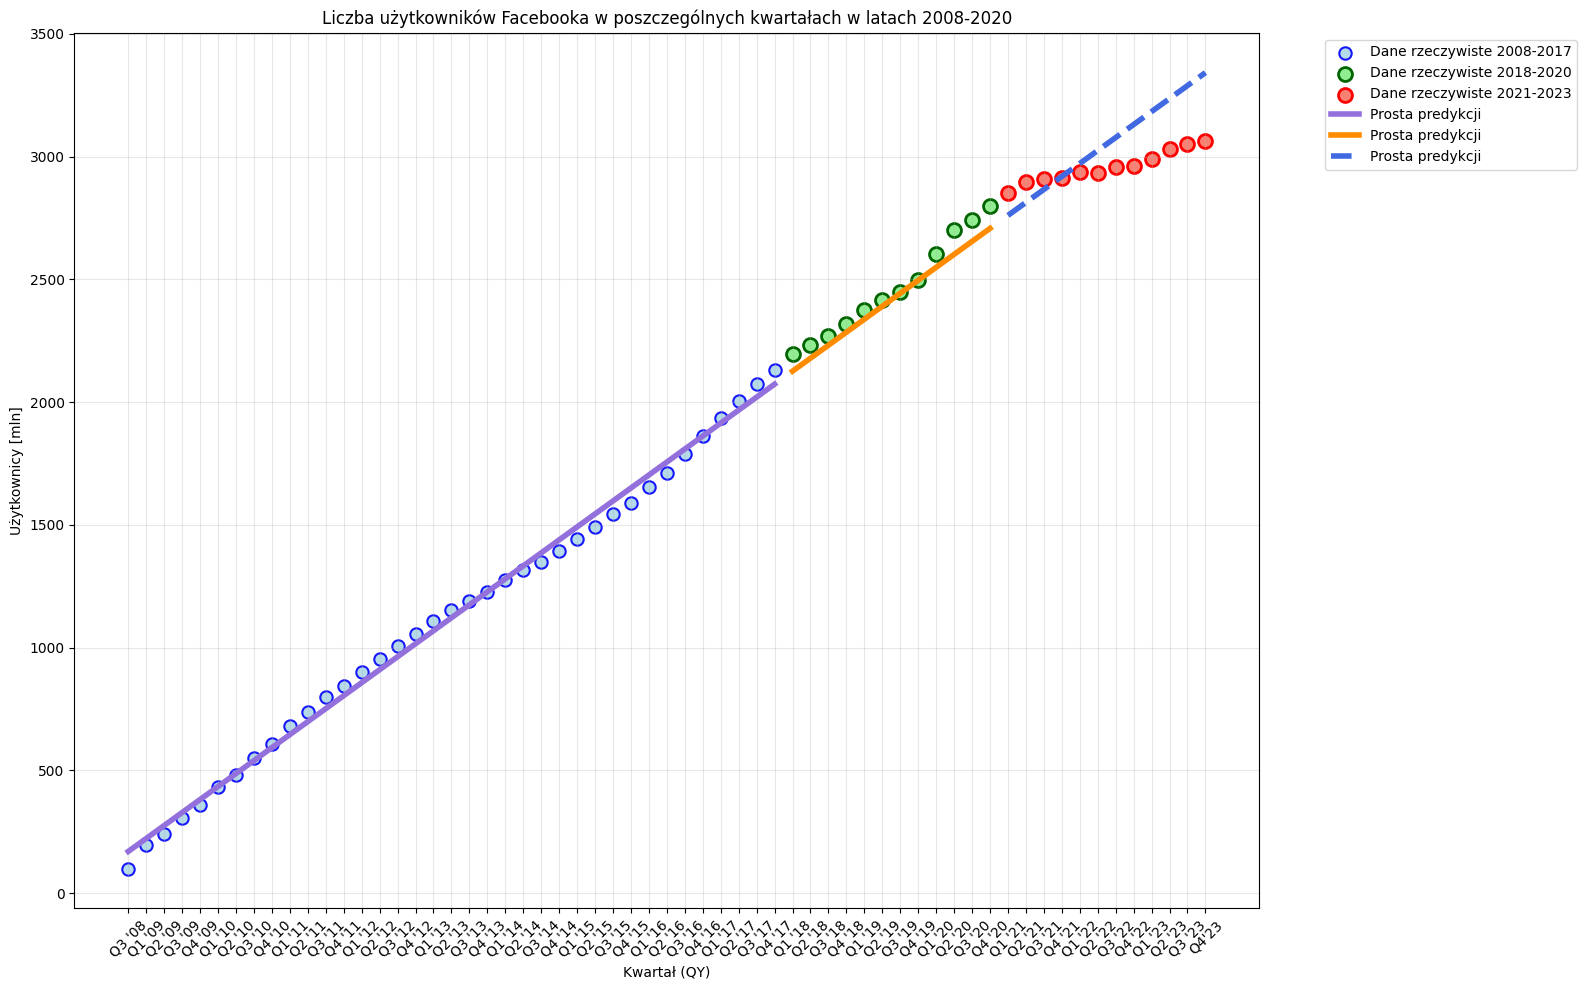

In [ ]:
# wykres z podzialem na training i test data 2018-2020, 2021-2023
plt.figure(figsize=(16,10))

# rzeczywiste dane
plt.scatter(train_data['QY'], y_train, s=80, label=f'Dane rzeczywiste 2008-2017',
            color='lightblue', edgecolors='blue', linewidth=1.5, alpha=0.9)
plt.scatter(test_18_20['QY'], y_18_20, s=100, label=f'Dane rzeczywiste 2018-2020',
            color='lightgreen', edgecolors='darkgreen', linewidth=2)
plt.scatter(test_21_23['QY'], y_21_23, s=100, label=f'Dane rzeczywiste 2021-2023',
            color='salmon', edgecolors='red', linewidth=2)

# linia regresji
plt.plot(train_data['QY'], model_linear.predict(X_linear), 'mediumpurple', linewidth=4,
         label=f'Prosta predykcji')
plt.plot(test_18_20['QY'], pred_18_20, 'darkorange', linewidth=4,
         label=f'Prosta predykcji')
plt.plot(test_21_23['QY'], pred_21_23, 'royalblue', linestyle="dashed", linewidth=4,
         label=f'Prosta predykcji')


plt.title('Liczba użytkowników Facebooka w poszczególnych kwartałach w latach 2008-2020')
plt.xlabel('Kwartał (QY)'); plt.ylabel('Użytkownicy [mln]')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


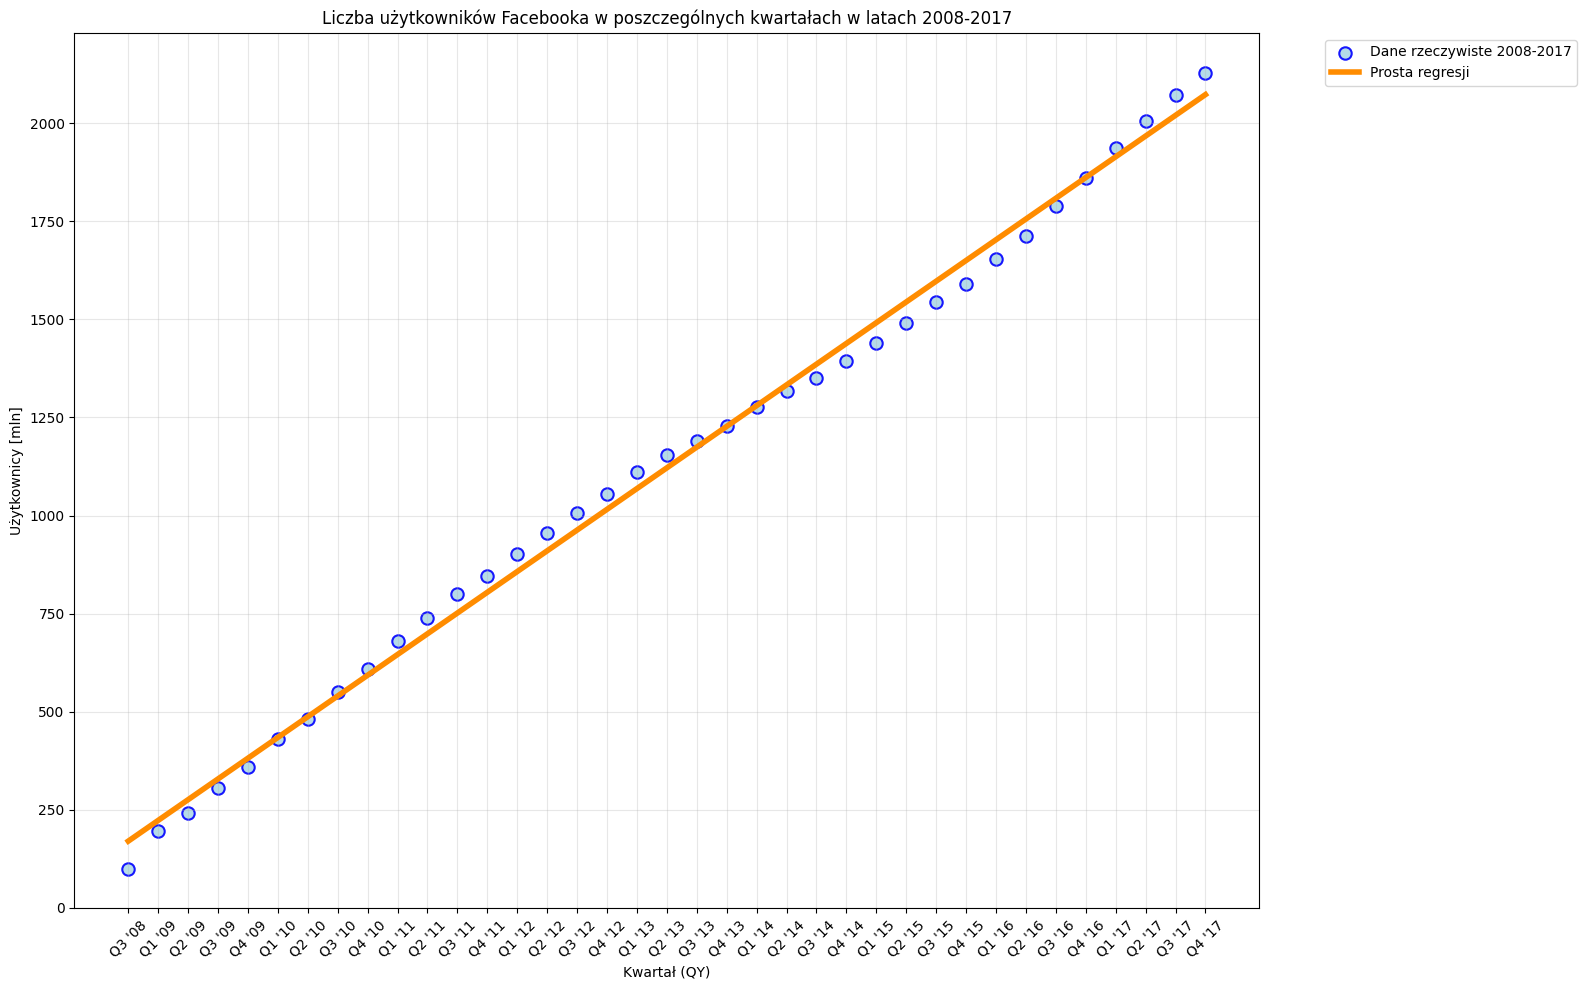

In [ ]:
# wykres z podzialem na training i test data 2018-2020, 2021-2023
plt.figure(figsize=(16,10))

# rzeczywiste dane
plt.scatter(train_data['QY'], y_train, s=80, label=f'Dane rzeczywiste 2008-2017',
            color='lightblue', edgecolors='blue', linewidth=1.5, alpha=0.9)
# plt.scatter(test_18_20['QY'], y_18_20, s=100, label=f'Dane rzeczywiste 2018-2020',
#             color='lightgreen', edgecolors='darkgreen', linewidth=2)
# plt.scatter(test_21_23['QY'], y_21_23, s=100, label=f'Dane rzeczywiste 2021-2023',
#             color='salmon', edgecolors='red', linewidth=2)

# linia regresji
plt.plot(train_data['QY'], model_linear.predict(X_linear), 'darkorange', linewidth=4,
         label=f'Prosta regresji')


plt.title('Liczba użytkowników Facebooka w poszczególnych kwartałach w latach 2008-2017')
plt.xlabel('Kwartał (QY)'); plt.ylabel('Użytkownicy [mln]')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

In [ ]:
df_2 = pd.read_csv("Users_RevenueY2007_2024.csv", delimiter=";")
df_2.dropna(inplace=True)

In [ ]:
df_2.head()
# df_2.tail()

,Year,NoY,Revenue,Users
1,2008,2,272,124.0
2,2009,3,777,276.0
3,2010,4,1974,517.0
4,2011,5,3711,766.0
5,2012,6,5089,979.0


Optymalne alfa: 0.971
RMSE potegowy   : 21506.96
RMSE wykladniczy: 511991.44
RMSE złożenie    : 15117.25
ME: -8837.5009
MAE: 13147.1898
RMSE: 15117.2479
R2: 0.7124

=== 2008–2017 (dopasowanie) ===
ME : -492.52892332683916
MAE: 1276.1522324436664
RMSE: 2241.2871254733222
R2 : 0.9685679912858128
S  : 2362.524068969097
We : 0.1995712171793459

=== MODEL POTĘGOWY ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1621.
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           1.59e-10
Time:                        19:08:19   Log-Likelihood:                 8.2586
No. Observations:                  10   AIC:                            -12.52
Df Residuals:                       8   BIC:                            -11.91
Df

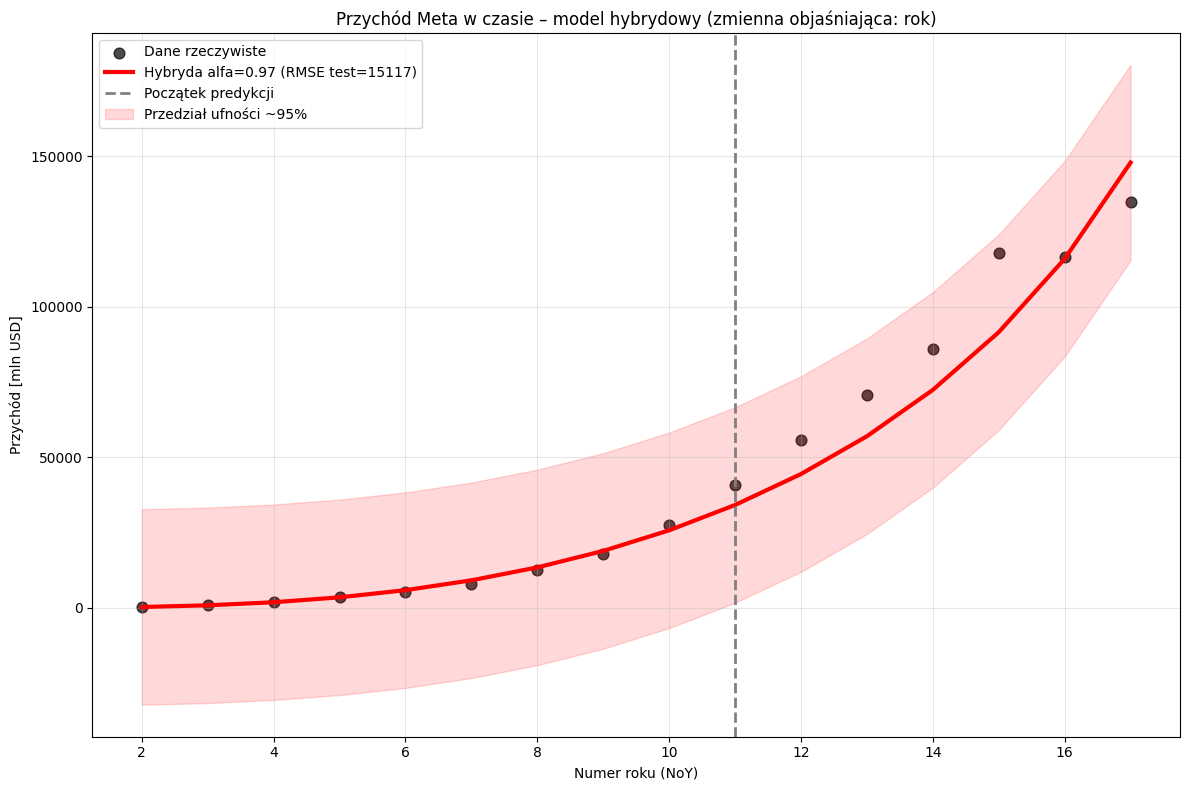

In [111]:
import numpy as np
import statsmodels.api as sm
from scipy.optimize import minimize_scalar
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


def ME(y_true, y_pred):
    return np.mean(y_pred - y_true)

def MAE(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


x_train = df_2[df_2["Year"] <= 2017]["NoY"].values
x_test  = df_2[df_2["Year"] > 2017]["NoY"].values
y_train = df_2[df_2["Year"] <= 2017]["Revenue"].values
y_test  = df_2[df_2["Year"] > 2017]["Revenue"].values



# potegowy log(y) = a0 + a1 * log(t)
X_train_pow = sm.add_constant(np.log(x_train))
model_pow = sm.OLS(np.log(y_train), X_train_pow).fit()

# wykladniczy log(y) = b0 + b1 * t
X_train_exp = sm.add_constant(x_train)
model_exp = sm.OLS(np.log(y_train), X_train_exp).fit()


X_test_pow = sm.add_constant(np.log(x_test))
X_test_exp = sm.add_constant(x_test)

pred_pow = np.exp(model_pow.predict(X_test_pow))   # f_potegowy(t)
pred_exp = np.exp(model_exp.predict(X_test_exp))   # f_wykladniczy(t)


def hybrid_rmse(alpha): # ?????
    # f_hyb = alfa * f_potegowy + (1-alfa) * f_wykladniczy
    pred_hyb = alpha * pred_pow + (1 - alpha) * pred_exp
    return RMSE(y_test, pred_hyb)

res = minimize_scalar(hybrid_rmse, bounds=(0, 1), method='bounded')
alpha_opt = res.x

print(f"Optymalne alfa: {alpha_opt:.3f}")
print(f"RMSE potegowy   : {RMSE(y_test, pred_pow):.2f}")
print(f"RMSE wykladniczy: {RMSE(y_test, pred_exp):.2f}")

pred_hybrid = alpha_opt * pred_pow + (1 - alpha_opt) * pred_exp
print(f"RMSE złożenie    : {RMSE(y_test, pred_hybrid):.2f}")

metrics_hyb = {
    "ME":   ME(y_test, pred_hybrid),
    "MAE":  MAE(y_test, pred_hybrid),
    "RMSE": RMSE(y_test, pred_hybrid),
    "R2":   r2_score(y_test, pred_hybrid)
}

for k, v in metrics_hyb.items():
    print(f"{k}: {v:.4f}")

# predykcje na TRAIN
X_train_pow_full = sm.add_constant(np.log(x_train))
X_train_exp_full = sm.add_constant(x_train)

pred_pow_train = np.exp(model_pow.predict(X_train_pow_full))
pred_exp_train = np.exp(model_exp.predict(X_train_exp_full))
pred_hybrid_train = alpha_opt * pred_pow_train + (1 - alpha_opt) * pred_exp_train

# metryki dopasowania na 2008–2017
residuals_hyb_train = y_train - pred_hybrid_train
ss_res_hyb_train = np.sum(residuals_hyb_train ** 2)
n_train = len(y_train)
s_hyb_train = np.sqrt(ss_res_hyb_train / (n_train - 1))
y_mean_train = np.mean(y_train)
We_hyb_train = s_hyb_train / y_mean_train

print("\n=== 2008–2017 (dopasowanie) ===")
print("ME :", ME(y_train, pred_hybrid_train))
print("MAE:", MAE(y_train, pred_hybrid_train))
print("RMSE:", RMSE(y_train, pred_hybrid_train))
print("R2 :", r2_score(y_train, pred_hybrid_train))
print("S  :", s_hyb_train)
print("We :", We_hyb_train)
print("\n=== MODEL POTĘGOWY ===")
print(model_pow.summary())

print("\n=== MODEL WYKŁADNICZY ===")
print(model_exp.summary())


x_all = df_2["NoY"].values
y_all = df_2["Revenue"].values

X_all_pow = sm.add_constant(np.log(x_all))
X_all_exp = sm.add_constant(x_all)

log_y_hat_pow_all = model_pow.predict(X_all_pow)
y_hat_pow_all = np.exp(log_y_hat_pow_all)

log_y_hat_exp_all = model_exp.predict(X_all_exp)
y_hat_exp_all = np.exp(log_y_hat_exp_all)

y_hat_hyb_all = alpha_opt * y_hat_pow_all + (1 - alpha_opt) * y_hat_exp_all

# wszystko z predykcją
plt.figure(figsize=(12, 8))

plt.scatter(x_all, y_all, s=60, color='black', alpha=0.7,
            label='Dane rzeczywiste')

plt.plot(x_all, y_hat_hyb_all, color='red', linewidth=3,
         label=f'Hybryda alfa={alpha_opt:.2f} (RMSE test={RMSE(y_test, pred_hybrid):.0f})')

plt.axvline(x=11, color='gray', linestyle='--', linewidth=2,
            label='Początek predykcji')

z = 1.96  # dla 95% przedziału ufności
upper = y_hat_hyb_all + z * s_hyb
lower = y_hat_hyb_all - z * s_hyb
plt.fill_between(x_all, lower, upper, color='red', alpha=0.15,
                 label='Przedział ufności ~95%')


plt.xlabel('Numer roku (NoY)')
plt.ylabel('Przychód [mln USD]')
plt.title('Przychód Meta w czasie – model hybrydowy (zmienna objaśniająca: rok)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



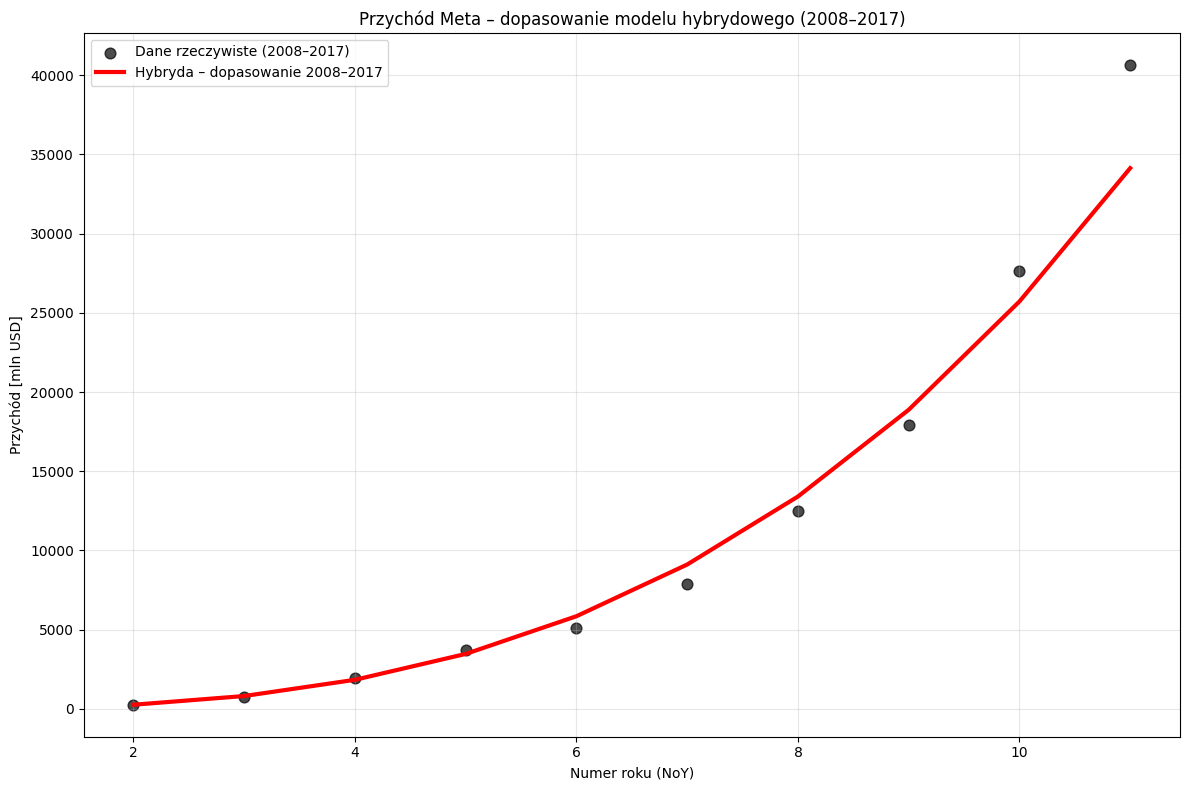

In [112]:
# DOPASOWANIE
plt.figure(figsize=(12, 8))

plt.scatter(x_train, y_train, s=60, color='black', alpha=0.7,
            label='Dane rzeczywiste (2008–2017)')

plt.plot(x_train, pred_hybrid_train, color='red', linewidth=3,
         label='Hybryda – dopasowanie 2008–2017')

plt.xlabel('Numer roku (NoY)')
plt.ylabel('Przychód [mln USD]')
plt.title('Przychód Meta – dopasowanie modelu hybrydowego (2008–2017)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()